In [1]:
# 손글씨자료를 딥러닝(뉴럴 네트워크:출력값이 많이 나옴)으로 학습해 예측
#!pip install tensorflow-gpu 

In [2]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
tf.__version__

'2.5.0'

In [4]:
import struct, os

In [5]:
def load_mnist(path, kind="train"): # load_mnist라는 함수 생성 / 파일을 4개 읽을 것이므로 경로와 kind의 변수로 train으로 설정
    labels_path = os.path.join(path, "%s-labels-idx1-ubyte"%kind) #label file
    images_path = os.path.join(path, "%s-images-idx3-ubyte"%kind) #image file / idx3 : 3차원
    # label에 관련된 처리
    with open(labels_path,"rb") as la_path:
        magic,n = struct.unpack(">II", la_path.read(8)) # 두개를 읽어올 것임 / la_path.read(8) : 8바이트로 읽음
        labels = np.fromfile(la_path,dtype=np.uint8) #test용 label을 읽을 수 있고 train용 label을 읽을 수도 있음
    # image에 관련된 처리
    with open(images_path, "rb") as img_path:
        magic, num, rows, cols = struct.unpack(">IIII",img_path.read(16))
        images = np.fromfile(img_path,dtype=np.uint8).reshape(len(labels),28**2)
        images = ((images/255)-0.5)*2 #나눠서 0에서 1사이로 바꿔준다 / -0.5 : -0.5에서 0.5사이 / *2를 함으로써 -1과 1사이를 수행하도록 해서 표준화(standard scaling)
    # 두개의 처리가 모두 끝나면 return
    return images, labels

In [6]:
X_train, y_train = load_mnist("./",kind="train") #주피터와 파일이 같은 경로에 있어야 함
X_test, y_test = load_mnist("./",kind="t10k")
X_valid, y_valid = X_train[50000:,:], y_train[50000:]
X_train, y_train = X_train[:50000,:], y_train[:50000]
print(X_valid.shape[0],X_valid.shape[1]) #valid, train 재조정
print(X_train.shape[0],X_train.shape[1]) #X_train이 총 60,000개 
print(X_test.shape[0],X_test.shape[1])

10000 784
50000 784
10000 784


In [7]:
mean_vals = np.mean(X_train,axis=0) # 다시 정규화
std_val = np.std(X_train)
X_train_centered = (X_train-mean_vals)/std_val #표준화
X_valid_centered = (X_valid-mean_vals)/std_val #X_valid도 전처리
X_test_centered = (X_test-mean_vals)/std_val

In [8]:
y_train_onehot = tf.keras.utils.to_categorical(y_train) #범주형으로 10000,01000,00100 이렇게 바꿈
y_valid_onehot = tf.keras.utils.to_categorical(y_valid)
y_test_onehot = tf.keras.utils.to_categorical(y_test)
y_train_onehot[:3]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
y_train[:3]

array([5, 0, 4], dtype=uint8)

In [10]:
#구조물
model = tf.keras.models.Sequential() #Sequential정보를 만들어놓고 add함

#layer가 3개니까 model도 3개
model.add(tf.keras.layers.Dense(units = 50, #Denser는 일반적인 layer
                                input_dim = X_train_centered.shape[1],
                                kernel_initializer = 'glorot_uniform', #'glorot_uniform' : 균일하게 나갈 것 
                                bias_initializer = 'zeros',
                                activation = 'tanh')) #'tanh' : 다음에 어떻게 보낼지는 layer에게 줘라
model.add(tf.keras.layers.Dense(units = 50, 
                                input_dim = 50, #784개의 입력을 받고 출력이 50개라 50개로 연결하므로 50이라 적어줌 (50보다 적어도 됌)
                                kernel_initializer = 'glorot_uniform',
                                bias_initializer = 'zeros',
                                activation = 'tanh'))
model.add(tf.keras.layers.Dense(units = 10, #출력에 맞게끔 줄임(답과 연결시켜야 하므로) 
                                input_dim = 50, # 이전 layer이 50개로 들어옴
                                kernel_initializer = 'glorot_uniform',
                                bias_initializer = 'zeros',
                                activation = 'softmax')) #근사값을 들어 %를 사용해 확률적으로 답을 줌

In [11]:
model.summary() #tensorflow한 뒤 summary하면 편함

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [12]:
sgd_optimizer = tf.keras.optimizers.SGD(lr=0.0001,decay=1e-7,momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss="categorical_crossentropy") #optimizer두개를 결합 -> compile

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
# 만들어진 model을 fitting
model.fit(X_train_centered, y_train_onehot, batch_size=64,epochs=50, verbose=1,validation_split=0.1) # validation_split로 중간중간마다 안정화되는 방향으로 틀어야 함()

Epoch 1/50
704/704 [==============================] - 1s 967us/step - loss: 1.6461 - val_loss: 1.2222
Epoch 2/50
704/704 [==============================] - 1s 845us/step - loss: 1.0412 - val_loss: 0.9223
Epoch 3/50
704/704 [==============================] - 1s 804us/step - loss: 0.8282 - val_loss: 0.7736
Epoch 4/50
704/704 [==============================] - 1s 844us/step - loss: 0.7088 - val_loss: 0.6809
Epoch 5/50
704/704 [==============================] - 1s 762us/step - loss: 0.6305 - val_loss: 0.6171
Epoch 6/50
704/704 [==============================] - 1s 790us/step - loss: 0.5747 - val_loss: 0.5704
Epoch 7/50
704/704 [==============================] - 1s 772us/step - loss: 0.5327 - val_loss: 0.5348
Epoch 8/50
704/704 [==============================] - 1s 775us/step - loss: 0.5000 - val_loss: 0.5065
Epoch 9/50
704/704 [==============================] - 1s 816us/step - loss: 0.4736 - val_loss: 0.4837
Epoch 10/50
704/704 [==============================] - 1s 972us/step - loss: 0.451

In [14]:
y_train_pred = model.predict_classes(X_train_centered,verbose=0)
y_train_pred[:3]

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([5, 0, 4], dtype=int64)

In [15]:
y_train[:3]

array([5, 0, 4], dtype=uint8)

In [16]:
#총 predict결과
total_predicts = np.sum(y_train==y_train_pred,axis=0)
print(total_predicts)
train_res = total_predicts/y_train.shape[0]
print(train_res)

46546
0.93092


In [17]:
y_test_pred = model.predict_classes(X_test_centered,verbose=0)
y_test_pred[:3]

array([7, 2, 1], dtype=int64)

In [18]:
y_test[:3]

array([7, 2, 1], dtype=uint8)

In [19]:
total_predicts = np.sum(y_test==y_test_pred,axis=0)
print(total_predicts)
test_res = total_predicts/y_test.shape[0]
print(test_res)

9307
0.9307


In [20]:
n=0
for i, x in enumerate(y_test):
    if x != y_test_pred[i]:
        print(i,x,y_test_pred[i])
        n+=1
print(n)

8 5 6
33 4 6
66 6 7
92 9 4
124 7 4
149 2 4
187 5 8
193 9 4
195 3 5
211 5 7
233 8 7
241 9 8
247 4 2
259 6 0
261 5 1
290 8 4
300 4 6
313 3 5
320 9 7
321 2 7
340 5 3
341 6 4
352 5 0
358 7 9
362 2 7
389 9 7
403 8 9
406 5 0
412 5 3
435 8 7
444 2 8
445 6 0
448 9 8
449 3 5
478 5 8
479 9 3
495 8 0
502 5 3
507 3 5
531 3 6
543 8 3
551 7 1
565 4 9
578 3 2
582 8 2
591 8 3
613 2 8
619 1 8
627 9 4
628 3 9
629 2 6
658 7 4
659 2 8
684 7 3
691 8 4
707 4 9
714 8 5
717 0 6
720 5 8
728 2 8
740 4 9
741 2 8
760 4 9
781 8 5
791 5 9
839 8 3
844 8 7
857 5 3
882 9 7
898 7 8
924 2 7
938 3 5
939 2 0
944 3 5
947 8 9
950 7 2
959 4 5
965 6 0
982 3 8
1003 5 8
1014 6 5
1017 6 2
1032 5 8
1039 7 9
1044 6 8
1050 2 6
1062 3 7
1068 8 4
1082 5 3
1101 8 2
1107 9 3
1112 4 6
1114 3 8
1119 7 2
1124 8 7
1128 3 7
1131 5 4
1173 7 9
1181 6 1
1182 6 8
1191 0 4
1192 9 4
1194 7 9
1198 8 4
1200 8 3
1202 8 5
1204 3 8
1206 7 2
1224 2 6
1226 7 2
1232 9 4
1234 8 5
1242 4 9
1247 9 0
1248 8 5
1256 2 3
1260 7 1
1283 7 2
1289 5 9
1291 3 5
1299

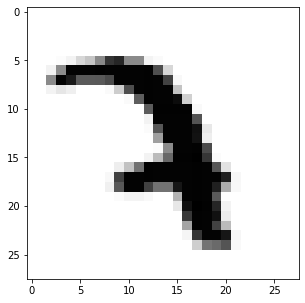

In [21]:
plt.figure(figsize=(5,5))
image = np.reshape(X_test[684],[28,28])
plt.imshow(image,cmap='Greys')
plt.show()

In [22]:
# CNN (Convolutional Neural Network)

In [23]:
#28*28짜리 이미지를 가져와서
from tensorflow.keras import layers, models
model = models.Sequential()
model.add(layers.Conv2D(32,(5,5), padding='valid', activation='relu', input_shape=(28,28,1))) #32로 깊이가 깊어진만큼 가로세로사이즈가 줄어듦
model.add(layers.MaxPool2D(2,2)) #줄이는 것 : 가로세로가 반절로 줄어듦(깊이는 변하지 않음)
model.add(layers.Conv2D(64,(5,5), padding='valid', activation='relu')) #깊이를 두배로 늘림(그만큼 부피가 유지되느라 가로세로가 줄어듦)
model.add(layers.MaxPool2D(2,2)) #그림이 점점 작아짐
model.add(layers.Flatten()) #4*4*64 = 1024(reshape과 비슷)
model.add(layers.Dense(1024,activation='relu')) #학습을 함
model.add(layers.Dropout(0.5)) #dense에 영향을 미쳐서 50% 효율로 껐다켰다하면서 막음
model.add(layers.Dense(10,activation='softmax')) #마지막 dense는 대답을 하는 학습을 함
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)             

In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=["acc"])

In [25]:
# fitting결과를 history에 담아보기
history = model.fit(X_train_centered, y_train_onehot, batch_size=64,epochs=20,validation_data=(X_valid_centered,y_valid_onehot))

Epoch 1/20


ValueError: in user code:

    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:230 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 784)


In [ ]:
plt.plot(np.arange(1,21),history.history['loss'],label="loss")
plt.plot(np.arange(1,21),history.history['val_loss'],label="val_loss")
plt.legend()
plt.show()

In [ ]:
np.argmax(model.predict(X_test_centered[:10]), axis=1)

In [ ]:
print(y_test[:10])